<a href="https://colab.research.google.com/github/jacomyma/dtu-sts-material/blob/main/notebooks/colab/Retrieve_subcorpus_Filter_and_export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieve subcorpus - Filter and export

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Filter the dataset using a condition (a **query**)
- Save the result as a CSV and/or as text

**Purpose**:
- Export a subcorpus CSV into another tool (ex: a spreadsheet)
- Export the content as text to read it manually

**How to use**:
- Edit settings if you want
- Then use "Runtime > Run all" or execute from the edited cell and below
- Wait for each cell to run
- ⚠️ Allow the script to access your Google Drive data when prompted to.
- **Edit the query** as you see fit
- Re-run that cell and the following ones to save the subcorpus
- **Download** the subcorpus as CSV and/or text


## Code

(You don't have to understand what's going on here, but feel free to take a look)

In [ ]:
# Additional settings you shouldn't have to change
settings = {}
settings['statements_spreadsheet_drive_URL'] = 'https://docs.google.com/spreadsheets/d/1cSwVVXAB7kYRbGKEr6gc5IGs955dIfJNcCzyl_cywa8/edit?usp=drive_link'

### Install stuff
Note: already installed libraries will not be reinstalled, don't worry about re-running that.

In [ ]:
#!pip install pandas gspread==5.10.0 google-auth==2.22.0 google-auth-oauthlib==1.0.0 google-auth-httplib2==0.1.0 bokeh
!pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2 bokeh

In [ ]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

import bokeh
import bokeh.plotting as bp
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.transform import factor_cmap

### Load data from the corpus

In [ ]:
# Open the spreadsheet by its key or URL
spreadsheet_key = settings['statements_spreadsheet_drive_URL'].split('/d/')[1].split('/edit')[0]
sh = gc.open_by_key(spreadsheet_key)

# Select the worksheet
worksheet_name = 'dataset'
worksheet = sh.worksheet(worksheet_name)

In [ ]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0])

# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

# Display dataframe for monitoring purposes
#df
print('Data loaded.')

Data loaded.


### Other prep we need

In [ ]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Filtering condition (QUERY)

**Edit the condition (the query)**, then run this cell and those below to update them. Also give a title to your query for clarity.

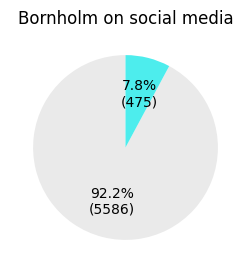

In [ ]:
# EDIT ME
condition = (
    (df['Statement'].str.contains('Bornholm', case=False, na=False))
  & (df['Source type'] == "Social media")
)

# EDIT ME (give an appropriate title to the query)
title = "Bornholm on social media"

# Check that it works
visualize(condition, title)

# Extract subcorpus

In [ ]:
# Extract
df_sub = df.copy()
df_sub = df_sub[condition]

In [ ]:
# Sanitize the title to create a valid filename
import re
# Replace any character that is not a letter, number, space, or underscore with an underscore
sanitized_title = re.sub(r'[^\w\s-]', '', title)
# Replace spaces with underscores
sanitized_title = sanitized_title.replace(' ', '_')

# Save as CSV

In [ ]:
# Save as CSV using the sanitized title for name
df_sub.to_csv(sanitized_title + '.csv', index=False)

print(f"Subcorpus saved as {sanitized_title}.csv. Download the file from the sidebar on the left.")

Subcorpus saved as Bornholm_on_social_media.csv. Download the file from the sidebar on the left.


# Save as text

Note: formatted in Markdown.

In [ ]:
def fillMarkdownTemplate(id, actorName, actorStatement, publicationDate, source):
  return f'''# {id}

*{actorName}, stated(†) on {source}, the {publicationDate}:*

{actorStatement}


'''

def makeMarkdown(df, filename):
  # Fill template for each row
  markdown = ''
  for index, row in df.iterrows():
    actor = df.at[index, 'Actor']
    if df.at[index, 'Representative of']:
      actor += ", "+df.at[index, 'Representative of']
    if df.at[index, 'Actor context']:
      actor += f" ({df.at[index, 'Actor context']})"

    source = df.at[index, 'Source name']
    if df.at[index, 'Source type']:
      source += " ("+df.at[index, 'Source type']+")"
    markdown += fillMarkdownTemplate(df.at[index, 'id'], actor, df.at[index, 'Statement'], df.at[index, 'Date of publication'], source)
  markdown += '\n\n# IMPORTANT NOTE ABOUT STATEMENTS\n\n(†) The original statements have been modified to facilitate the data science process.'

  # Save markdown as file
  with open(filename, 'w') as f:
    f.write(markdown)
  print(f'File created: {filename}. Download the file from the sidebar on the left.')

makeMarkdown(df_sub, sanitized_title + '.txt')

File created: Bornholm_on_social_media.txt. Download the file from the sidebar on the left.
